# Summary

----

# Imports

In [1]:
%run imports.ipynb

elaspic_training_set
2016-06-08 10:15:36.082862


In [2]:
NOTEBOOK_NAME = 'core_machine_learning'

# Load data

In [3]:
with open(op.join('load_data', 'TRAINING_SETS.pkl'), 'rb') as ifh:
    TRAINING_SETS = pickle.load(ifh)
print(TRAINING_SETS.keys())

dict_keys(['humsavar', 'protherm', 'taipale'])


In [4]:
db = datapkg.DataFrameToMySQL(CONNECTION_STR, NOTEBOOK_NAME, STG_SERVER_IP, echo=False)

## TRAINING_SETS_NONULL

In [5]:
# Remove rows with missing features
TRAINING_SETS_NONULL = dict()
for key, df in TRAINING_SETS.items():
    _shape_before = df.shape[0]
    df = df.dropna(subset=elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE, how='any')
    df = df.dropna(subset=['ddg_exp', 'del_score_exp', 'del_class_exp'], how='all')
    _shape_after = df.shape[0]
    TRAINING_SETS_NONULL[key] = df

    print(key)
    print("Shape before:\t{:,d}".format(_shape_before))
    print("Shape after:\t{:,d}".format(_shape_after))
    print("Rows lost:\t{:,d}".format(_shape_before - _shape_after))
    print('-' * 40)

humsavar
Shape before:	33,253
Shape after:	30,388
Rows lost:	2,865
----------------------------------------
protherm
Shape before:	3,792
Shape after:	3,230
Rows lost:	562
----------------------------------------
taipale
Shape before:	1,919
Shape after:	1,871
Rows lost:	48
----------------------------------------


In [6]:
data_file = op.abspath(op.join(NOTEBOOK_NAME, 'TRAINING_SETS_NONULL.pkl'))
with open(data_file, 'wb') as ofh:
    pickle.dump(TRAINING_SETS_NONULL, ofh, pickle.HIGHEST_PROTOCOL)

# Regression

In [7]:
from sklearn import cross_validation, grid_search, ensemble

In [8]:
# Generate a list of parameters that we want to try...
FEATURE_COLUMNS = elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE[:]
FEATURE_COLUMNS.remove('dg_change')

parameter_grid =  {
    'data_set': ['protherm'],
    'n_estimators': [2000],
    'loss': ['huber'],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_depth': [4, 6,   8, 10],
    'min_samples_leaf': [3, 5, 9, 13, 17,   21, 29],
    'max_features': [1.0, 0.3, 0.1,   0.8, 0.5],
    'alpha': [0.99, 0.95, 0.9, 0.8, 0.7, 0.5],
    'features': [':'.join(FEATURE_COLUMNS)],
}

def iter_system_command(parameter_grid, _previous=None):
    if _previous is None:
        _previous_job_ids, _previous_system_commands = set(), set()
    else:
        _previous_job_ids, _previous_system_commands = (set(x) for x in zip(*_previous))
    #
    job_id = 0
    for param_dict in ascommon.cluster_tools.iterate_parameters(parameter_grid):
        system_command = (
            "{python} {script} {args}".format(
                python=sys.executable,
                script=op.abspath(op.join(NOTEBOOK_NAME, '_reg_gridsearch.py')),
                args=' '.join(sorted("--{} {}".format(*x) for x in param_dict.items())))
        )
        if system_command in _previous_system_commands:
            continue
        while job_id in _previous_job_ids:
            job_id += 1
        yield (job_id, system_command)
        job_id += 1

if False:
    system_commands = list(iter_system_command(parameter_grid, system_commands_1))
    _system_commands = list(iter_system_command(parameter_grid))

    assert len(system_commands) == len(_system_commands) - len(system_commands_1), (
        (len(system_commands), len(_system_commands) - len(system_commands_1))
    )
else:
    system_commands = list(iter_system_command(parameter_grid))

print("Size of the parameter grid: ", len(system_commands))

Size of the parameter grid:  3360


## `_reg_gridsearch.py`

In [9]:
%%file $NOTEBOOK_NAME/_reg_gridsearch.py
import os
import os.path as op
import pickle
import json
import scipy as sp
import pandas as pd
import sqlalchemy as sa
from sklearn import ensemble, cross_validation, metrics
import elaspic


def cross_validate(df, valids, opts, features, do_xval, target='ddg_exp', label='pfam_clan'):
    clf = ensemble.GradientBoostingRegressor(**opts)
    # Training
    result = {}
    if do_xval:
        preds = cross_validation.cross_val_predict(
            estimator=clf,
            X=df[features],
            y=df[target],
            cv=cross_validation.LeaveOneLabelOut(df[label].fillna('')),
            n_jobs=1,
        )
        result = {
            'r2': metrics.r2_score(df[target], preds),
            'pearson_r': sp.stats.pearsonr(df[target], preds)[0],
            'spearman_r': sp.stats.spearmanr(df[target], preds)[0],
        }
    # Validation on our 'test' sets
    clf.fit(df[features], df[target])
    for d, df_valid in valids.items():
        _predicted = clf.predict(df_valid[features])
        for col_name, do_abs in [
                ('ddg_exp', False),
                ('del_score_exp', True),
                ('del_class_exp', True)]:
            if df_valid[col_name].notnull().all():
                m = 'ddg{}_vs_{}'.format('_abs' if do_abs else '', col_name)
                predicted = abs(_predicted) if do_abs else _predicted
                actual = df_valid[col_name].abs() if do_abs else df_valid[col_name]
                result['r2_{}_{}'.format(d, m)] = metrics.r2_score(actual, predicted)
                result['pearsonr_{}_{}'.format(d, m)] = sp.stats.pearsonr(actual, predicted)[0]
                result['spearmanr_{}_{}'.format(d, m)] = sp.stats.spearmanr(actual, predicted)[0]
    # DONE!
    return result


if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_set', type=str, required=True)
    parser.add_argument('--features', type=str, default=None)
    parser.add_argument('--do_xval', type=int, default=1)
    # 
    parser.add_argument('--learning_rate', type=float, required=True)
    parser.add_argument('--max_depth', type=int, required=True)
    parser.add_argument('--min_samples_leaf', type=int, required=True)
    parser.add_argument('--max_features', type=float, required=True)
    parser.add_argument('--alpha', type=float, required=True)
    #
    parser.add_argument('--loss', type=str, default='huber')
    parser.add_argument('--n_estimators', type=int, default=3000)
    #
    args = parser.parse_args()

    with open('{{ data_file }}', 'rb') as ifh:
        TRAINING_SETS = pickle.load(ifh)
    
    train_df = TRAINING_SETS[args.data_set]
    validation_dfs = {key: df_valid for (key, df_valid) in TRAINING_SETS.items() if key != args.data_set}
    clf_opts = {k: v for (k, v) in args.__dict__.items() if k not in ['data_set', 'features', 'do_xval']}
    if args.features is None:
        features = elaspic.elaspic_predictor.FEATURE_COLUMNS_CORE
    else:
        features = args.features.split(':')

    clf_result = cross_validate(train_df, validation_dfs, clf_opts, features, do_xval=bool(args.do_xval))

    result = {'clf_opts': clf_opts, **clf_result}
    print(json.dumps(result))

Overwriting core_machine_learning/_reg_gridsearch.py


In [10]:
!sed -i 's|{{{{ data_file }}}}|$data_file|g' '$NOTEBOOK_NAME/_reg_gridsearch.py'

In [11]:
!python $NOTEBOOK_NAME/_reg_gridsearch.py --data_set protherm --do_xval 0 \
    --learning_rate 0.1 --max_depth 4 --min_samples_leaf 3 --max_features 1.0 --alpha=0.95 --n_estimators 100

{"spearmanr_taipale_ddg_vs_ddg_exp": 0.04081403619847602, "max_depth": 4, "n_estimators": 100, "loss": "huber", "max_features": 1.0, "pearsonr_taipale_ddg_vs_ddg_exp": 0.014882219037281262, "min_samples_leaf": 3, "r2_humsavar_ddg_abs_vs_del_class_exp": -9.630203483870764, "spearmanr_humsavar_ddg_abs_vs_del_class_exp": 0.06434592736083841, "pearsonr_humsavar_ddg_abs_vs_del_class_exp": 0.010472147463413321, "r2_taipale_ddg_vs_ddg_exp": -0.47220379744381047, "alpha": 0.95, "learning_rate": 0.1}


### xv_wout_dg_change

**Iterate until all have finished successfully...**

The cross-validation score here is correct, but the validation scores used a wrong metric and have to be redone...

In [141]:
reload(ascommon)
reload(ascommon.cluster_tools)

<module 'ascommon.cluster_tools' from '/home/kimlab1/strokach/working/ascommon/ascommon/cluster_tools/__init__.py'>

In [143]:
# Run gridsearch on cluster
log_base_dir = op.abspath(op.join(NOTEBOOK_NAME, '_reg_gridsearch'))

js = ascommon.cluster_tools.JobSubmitter(
    'xv_wout_dg_change', 'sge://:@192.168.6.201', log_base_dir,
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='04:00:00', mem='2G'
)

In [144]:
results_df = js.job_status(system_commands)
print(Counter(results_df['status']))

Counter({'done': 3360})


In [145]:
failed = (
    set(results_df[results_df['status'] == 'running']['job_id']) |
    set(results_df[results_df['status'] == 'missing']['job_id']) |
    set(results_df[results_df['status'] == 'error']['job_id'])
)
print(failed)
print(len(failed))

set()
0


In [146]:
system_commands_remaining = [x for x in system_commands if x[0] in failed]
print(len(system_commands_remaining))

0


### xv_wout_dg_change_mod1

In [148]:
# Run gridsearch on cluster
js_mod1 = ascommon.cluster_tools.JobSubmitter(
    'xv_wout_dg_change_mod1', 'pbs://:@192.168.233.150', log_base_dir,
    email='ostrokach@gmail.com', force_new_folder=False,
    nproc=1, queue='medium', walltime='02:00:00', mem='2G',
    concurrent_job_limit=800
)

In [149]:
parameter_grid['do_xval'] = [0]
system_commands_mod1 = list(iter_system_command(parameter_grid))

In [150]:
with js_mod1.connect():
    print(js_mod1.get_num_running_jobs())

240


In [151]:
# Get job status
results_df_mod1 = js_mod1.job_status(system_commands)
print(Counter(results_df_mod1['status']))

Counter({'done': 3360})


In [152]:
results_df_mod1.head()

,alpha,job_id,learning_rate,loss,max_depth,max_features,min_samples_leaf,n_estimators,pearsonr_humsavar_ddg_abs_vs_del_class_exp,pearsonr_taipale_ddg_vs_ddg_exp,r2_humsavar_ddg_abs_vs_del_class_exp,r2_taipale_ddg_vs_ddg_exp,spearmanr_humsavar_ddg_abs_vs_del_class_exp,spearmanr_taipale_ddg_vs_ddg_exp,status,~system_command
0,0.99,0,0.1,huber,4,1.0,3,2000,0.044119,0.036948,-14.225524,-0.478178,0.079713,0.053315,done,/home/kimlab1/strokach/anaconda/bin/python /ho...
1,0.99,1,0.1,huber,4,0.3,3,2000,0.053696,0.055236,-12.490475,-0.456320,0.088908,0.071719,done,/home/kimlab1/strokach/anaconda/bin/python /ho...
2,0.99,2,0.1,huber,4,0.1,3,2000,0.076795,0.064772,-14.073619,-0.435374,0.115523,0.101880,done,/home/kimlab1/strokach/anaconda/bin/python /ho...
3,0.99,3,0.1,huber,4,0.8,3,2000,0.019709,0.023142,-17.827938,-0.506776,0.056946,0.045208,done,/home/kimlab1/strokach/anaconda/bin/python /ho...
4,0.99,4,0.1,huber,4,0.5,3,2000,0.040589,0.034567,-12.764324,-0.499547,0.078348,0.062535,done,/home/kimlab1/strokach/anaconda/bin/python /ho...


In [153]:
print(results_df_mod1['spearmanr_taipale_ddg_vs_ddg_exp'].max())
print(results_df_mod1['spearmanr_humsavar_ddg_abs_vs_del_class_exp'].max())

0.214059223932
0.284635659767


In [154]:
# Job statistics
failed = (
    set(results_df_mod1[results_df_mod1['status'] != 'done']['job_id'])
)
system_commands_mod1_remaining = [x for x in system_commands_mod1 if x[0] in failed]
print(len(system_commands_mod1_remaining))

0


### Results

In [155]:
results_df_all = results_df_mod1.merge(results_df, on=['job_id'], suffixes=('', '_old'))
results_df_all = results_df_all[[c for c in results_df_all.columns if not c.endswith('_old')]]
print(results_df.shape)
print(results_df_mod1.shape)
print(results_df_all.shape)

(3360, 34)
(3360, 16)
(3360, 34)


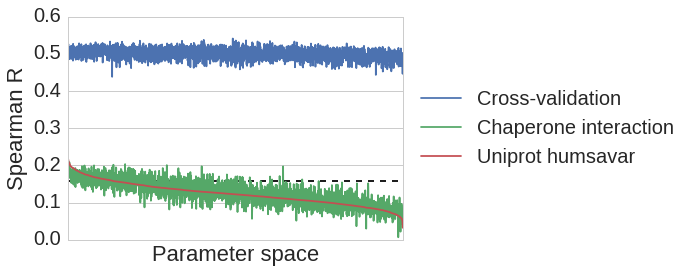

In [163]:
df = (
    results_df[['spearman_r', 'spearman_r_taipale', 'spearman_r_humsavar', ]]
    .dropna()
    .sort_values('spearman_r_humsavar', ascending=False)
)
df.index = range(df.shape[0])

ax = (
    df.rename(columns={
        'spearman_r': 'Cross-validation', 
        'spearman_r_humsavar': 'Uniprot humsavar',
        'spearman_r_taipale': 'Chaperone interaction'})
    .plot(xticks=[])
)
ax.set_xlabel('Parameter space')
ax.set_ylabel('Spearman R')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.hlines(0.159, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], colors='k', linestyles='--')

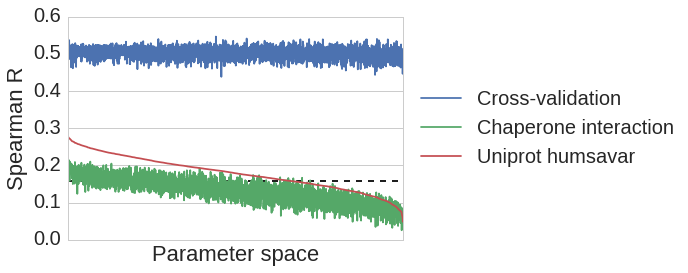

In [165]:
df = (
    results_df_all[['spearman_r', 'spearmanr_taipale_ddg_vs_ddg_exp', 'spearmanr_humsavar_ddg_abs_vs_del_class_exp', ]]
#     .dropna()
    .sort_values('spearmanr_humsavar_ddg_abs_vs_del_class_exp', ascending=False)
)
df.index = range(df.shape[0])

ax = (
    df
    .rename(columns={
        'spearman_r': 'Cross-validation', 
        'spearmanr_humsavar_ddg_abs_vs_del_class_exp': 'Uniprot humsavar',
        'spearmanr_taipale_ddg_vs_ddg_exp': 'Chaperone interaction'})
    .plot(xticks=[])
)
ax.set_xlabel('Parameter space')
ax.set_ylabel('Spearman R')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.hlines(0.159, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], colors='k', linestyles='--')

(3360, 5)


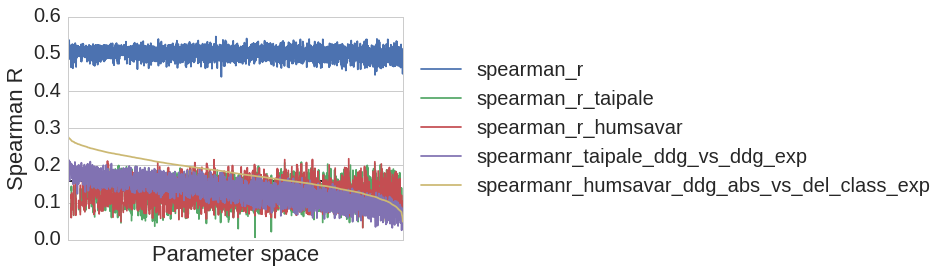

In [166]:
df = (
    results_df_all[[
        'spearman_r', 'spearman_r_taipale', 'spearman_r_humsavar', 
        'spearmanr_taipale_ddg_vs_ddg_exp', 'spearmanr_humsavar_ddg_abs_vs_del_class_exp']]
#     .dropna()
    .sort_values('spearmanr_humsavar_ddg_abs_vs_del_class_exp', ascending=False)
)
df.index = range(df.shape[0])
print(df.shape)

ax = (
    df
#     .rename(columns={
#         'spearman_r': 'Cross-validation', 
#         'spearman_r_humsavar': 'Uniprot humsavar',
#         'spearman_r_taipale': 'Chaperone interaction'})
    .plot(xticks=[])
)
ax.set_xlabel('Parameter space')
ax.set_ylabel('Spearman R')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.hlines(0.159, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], colors='k', linestyles='--')

In [162]:
df.corr()

,spearman_r,spearman_r_taipale,spearman_r_humsavar,spearmanr_taipale_ddg_vs_ddg_exp,spearmanr_humsavar_ddg_abs_vs_del_class_exp
spearman_r,1.000000,0.073764,0.302934,0.182738,0.199239
spearman_r_taipale,0.073764,1.000000,0.804781,0.003407,-0.054610
spearman_r_humsavar,0.302934,0.804781,1.000000,0.059759,0.035670
spearmanr_taipale_ddg_vs_ddg_exp,0.182738,0.003407,0.059759,1.000000,0.852820
spearmanr_humsavar_ddg_abs_vs_del_class_exp,0.199239,-0.054610,0.035670,0.852820,1.000000


In [167]:
results_df_all['spearmanr_avg'] = (
    results_df_all
    [['spearman_r', 'spearmanr_taipale_ddg_vs_ddg_exp', 'spearmanr_humsavar_ddg_abs_vs_del_class_exp']]
    .mean(axis=1, skipna=True)
)

best_row = (
    results_df_all[
        (results_df_all['spearmanr_avg'] == 
         results_df_all['spearmanr_avg'].max())
    ]
)
best_row

,alpha,job_id,learning_rate,loss,max_depth,max_features,min_samples_leaf,n_estimators,pearsonr_humsavar_ddg_abs_vs_del_class_exp,pearsonr_taipale_ddg_vs_ddg_exp,r2_humsavar_ddg_abs_vs_del_class_exp,r2_taipale_ddg_vs_ddg_exp,spearmanr_humsavar_ddg_abs_vs_del_class_exp,spearmanr_taipale_ddg_vs_ddg_exp,status,~system_command,pearson_r,pearson_r_humsavar,pearson_r_humsavar_del_class_exp,pearson_r_taipale,pearson_r_taipale_ddg_exp,pearson_r_uniprot_humsavar_del_class_exp,r2,r2_humsavar,r2_humsavar_del_class_exp,r2_taipale,r2_taipale_ddg_exp,r2_uniprot_humsavar_del_class_exp,spearman_r,spearman_r_humsavar,spearman_r_humsavar_del_class_exp,spearman_r_taipale,spearman_r_taipale_ddg_exp,spearman_r_uniprot_humsavar_del_class_exp,spearmanr_avg
3250,0.9,3250,0.01,huber,4,1.0,29,2000,0.279951,0.228576,-2.900861,-0.33157,0.273475,0.214059,done,/home/kimlab1/strokach/anaconda/bin/python /ho...,0.518429,NaN,NaN,NaN,NaN,NaN,0.263522,NaN,NaN,NaN,NaN,NaN,0.518728,NaN,NaN,NaN,NaN,NaN,0.335421


In [168]:
clf = ensemble.GradientBoostingRegressor(
    **best_row
    [[c for c in best_row.columns if 
      not c.startswith('pearson') and 
      not c.startswith('spearman') and
      not c.startswith('r2_') and
      c not in ['job_id', 'r2', 'status', '~system_command']]]
    .iloc[0]
)

(-5, 10)

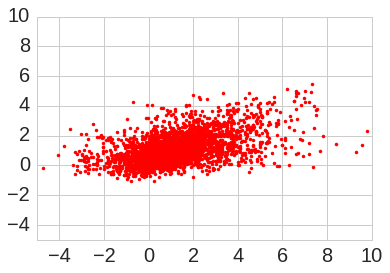

In [117]:
plt.plot(
    TRAINING_SETS_NONULL['protherm']['ddg_exp'],
    preds,
    'r.'
)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

In [118]:
clf.fit(TRAINING_SETS_NONULL['protherm'][FEATURE_COLUMNS], TRAINING_SETS_NONULL['protherm']['ddg_exp'])

GradientBoostingRegressor(alpha=0.5, init=None, learning_rate=0.01,
             loss='huber', max_depth=8, max_features=1.0,
             max_leaf_nodes=None, min_samples_leaf=13, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

(-5, 10)

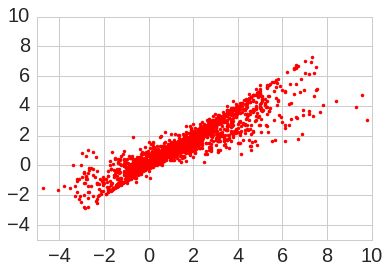

In [119]:
plt.plot(
    TRAINING_SETS_NONULL['protherm']['ddg_exp'],
    clf.predict(TRAINING_SETS_NONULL['protherm'][FEATURE_COLUMNS]),
    'r.'
)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

In [177]:
best_row = (
    results_df_all[
        (results_df_all['spearmanr_humsavar_ddg_abs_vs_del_class_exp'] == 
         results_df_all['spearmanr_humsavar_ddg_abs_vs_del_class_exp'].max())
    ]
)
best_row

,alpha,job_id,learning_rate,loss,max_depth,max_features,min_samples_leaf,n_estimators,pearsonr_humsavar_ddg_abs_vs_del_class_exp,pearsonr_taipale_ddg_vs_ddg_exp,r2_humsavar_ddg_abs_vs_del_class_exp,r2_taipale_ddg_vs_ddg_exp,spearmanr_humsavar_ddg_abs_vs_del_class_exp,spearmanr_taipale_ddg_vs_ddg_exp,status,~system_command,pearson_r,pearson_r_humsavar,pearson_r_humsavar_del_class_exp,pearson_r_taipale,pearson_r_taipale_ddg_exp,pearson_r_uniprot_humsavar_del_class_exp,r2,r2_humsavar,r2_humsavar_del_class_exp,r2_taipale,r2_taipale_ddg_exp,r2_uniprot_humsavar_del_class_exp,spearman_r,spearman_r_humsavar,spearman_r_humsavar_del_class_exp,spearman_r_taipale,spearman_r_taipale_ddg_exp,spearman_r_uniprot_humsavar_del_class_exp,spearmanr_avg
1885,0.5,1885,0.01,huber,8,1.0,13,2000,0.282678,0.202577,-2.080595,-0.359478,0.284636,0.20077,done,/home/kimlab1/strokach/anaconda/bin/python /ho...,0.511779,0.145618,NaN,0.134878,NaN,NaN,0.253459,-0.765847,NaN,-0.355445,NaN,NaN,0.51078,0.145618,NaN,0.137225,NaN,NaN,0.332062


In [178]:
print(sp.stats.spearmanr(
    TRAINING_SETS_NONULL['protherm']['dg_change'],
    TRAINING_SETS_NONULL['protherm']['ddg_exp']
)) 

print(results_df['spearman_r'].max())
print(best_row['spearman_r'].values)

SpearmanrResult(correlation=0.4837474998380899, pvalue=3.9533130322216697e-189)
0.546309381351
[ 0.51078041]


In [179]:
print(sp.stats.spearmanr(
    TRAINING_SETS_NONULL['taipale']['dg_change'],
    TRAINING_SETS_NONULL['taipale']['ddg_exp']
))

print(results_df_mod1['spearmanr_taipale_ddg_vs_ddg_exp'].max())
print(best_row['spearmanr_taipale_ddg_vs_ddg_exp'].values)

SpearmanrResult(correlation=0.15824654584787676, pvalue=5.827423107227806e-12)
0.214059223932
[ 0.20076973]


In [180]:
print(sp.stats.spearmanr(
    TRAINING_SETS_NONULL['humsavar']['dg_change'],
    TRAINING_SETS_NONULL['humsavar']['del_class_exp']
))

print(sp.stats.spearmanr(
    TRAINING_SETS_NONULL['humsavar']['dg_change'].abs(),
    TRAINING_SETS_NONULL['humsavar']['del_class_exp']
))

print(results_df_mod1['spearmanr_humsavar_ddg_abs_vs_del_class_exp'].max())
print(best_row['spearmanr_humsavar_ddg_abs_vs_del_class_exp'].values)

SpearmanrResult(correlation=0.2650639134545601, pvalue=0.0)
SpearmanrResult(correlation=0.27552368346295392, pvalue=0.0)
0.284635659767
[ 0.28463566]


In [ ]:
# FoldX vs.
taipale['dg_change_cls'] = ((taipale['dg_change'] < -0.5) | (taipale['dg_change'] > 1.5)).astype(int)
sp.stats.spearmanr(taipale['ddg_exp'], taipale['dg_change_cls'])

In [ ]:
# FoldX vs.
humsavar['dg_change_cls'] = ((humsavar['dg_change'] < -0.5) | (humsavar['dg_change'] > 1.5)).astype(int)
sp.stats.spearmanr(humsavar['ddg_exp'], humsavar['dg_change_cls'])

In [ ]:
sp.stats.spearmanr(humsavar['ddg_exp'], humsavar['dg_change'].abs())

In [ ]:
humsavar['ddg_exp'].hist()

In [ ]:
preds_valid = ((preds_valid < -0.5) | (preds_valid > 1.5)).astype(int)

In [ ]:
clf_opts = dict(
    n_estimators=2000,
    loss='huber',
    learning_rate=0.01,
    max_depth=4,
    min_samples_leaf=17,
    max_features=0.1,
    alpha=0.7,
)

In [ ]:
protherm_reg = ensemble.GradientBoostingRegressor(**clf_opts)

In [ ]:
protherm_reg

In [ ]:
protherm['ddg_pred'] = (
    cross_validation.cross_val_predict(
        protherm_reg, 
        protherm[FEATURE_COLUMNS],
        protherm['ddg_exp'], 
        cv=cross_validation.LeaveOneLabelOut(protherm['pfam_clan']),
        n_jobs=4)
)

In [ ]:
protherm_reg.fit(protherm[FEATURE_COLUMNS].values, protherm['ddg_exp'].values)

In [ ]:
taipale['ddg_pred_protherm'] = protherm_reg.predict(taipale[FEATURE_COLUMNS])

## Taipale

#### Grid search

In [ ]:
taipale_reg = ensemble.GradientBoostingRegressor(**clf_opts)

In [ ]:
taipale_reg

In [ ]:
gs_cv = grid_search.GridSearchCV(
    estimator=taipale_reg, 
    param_grid=param_grid, 
    n_jobs=8,
    cv=cross_validation.LeaveOneLabelOut(taipale['pfam_clan']),
).fit(taipale[FEATURE_COLUMNS], taipale['ddg_exp'])

In [ ]:
print(gs_cv.best_params_)
# 

#### Final regressor

In [ ]:
taipale_reg = ensemble.GradientBoostingRegressor(**clf_opts)

In [ ]:
taipale_reg

In [ ]:
taipale['ddg_pred'] = (
    cross_validation.cross_val_predict(
        taipale_reg, 
        taipale[FEATURE_COLUMNS],
        taipale['ddg_exp'],
        cv=cross_validation.LeaveOneLabelOut(taipale['pfam_clan']),
        n_jobs=4)
)

In [ ]:
taipale_reg.fit(taipale[FEATURE_COLUMNS].values, taipale['ddg_exp'].values)

In [ ]:
protherm['ddg_pred_taipale'] = taipale_reg.predict(protherm[FEATURE_COLUMNS])

## Plots

### Protherm

In [ ]:
fg, axes = plt.subplots(2, 2, figsize=(14, 10))

ascommon.plotting_tools.make_plot_with_corr('ddg_exp', 'dg_change', data=protherm, ax=axes[0, 0])
axes[0, 0].set_ylabel('$\Delta \Delta G$ FoldX')
axes[0, 0].set_xlabel('$\Delta \Delta G$')

ascommon.plotting_tools.make_plot_with_corr('ddg_exp', 'provean_score', data=protherm, ax=axes[0, 1])
axes[0, 1].set_ylabel('Provean score')
axes[0, 1].set_xlabel('$\Delta \Delta G$')

ascommon.plotting_tools.make_plot_with_corr('ddg_exp', 'ddg_pred', data=protherm, ax=axes[1, 0])
axes[1, 0].set_ylabel('$\Delta \Delta G$ cross-val')
axes[1, 0].set_xlabel('$\Delta \Delta G$')

ascommon.plotting_tools.make_plot_with_corr('ddg_exp', 'ddg_pred_taipale', data=protherm, ax=axes[1, 1])
axes[1, 1].set_ylabel('Taipale predictor score')
axes[1, 1].set_xlabel('$\Delta \Delta G$')

plt.tight_layout()

In [ ]:
# 0.216

### Taipale

In [ ]:
fg, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].set_ylim(-10, 40)
ascommon.plotting_tools.make_plot_with_corr('ddg_exp', 'dg_change', data=taipale, ax=axes[0, 0])
axes[0, 0].set_ylabel('$\Delta \Delta G$ FoldX')
axes[0, 0].set_xlabel('Chaperone interaction z-score')

ascommon.plotting_tools.make_plot_with_corr('ddg_exp', 'provean_score', data=taipale, ax=axes[0, 1])
axes[0, 1].set_ylabel('Provean score')
axes[0, 1].set_xlabel('Chaperone interaction z-score')

ascommon.plotting_tools.make_plot_with_corr('ddg_exp', 'ddg_pred', data=taipale, ax=axes[1, 0])
axes[1, 0].set_ylabel('Taipale score cross-val')
axes[1, 0].set_xlabel('Chaperone interaction z-score')

ascommon.plotting_tools.make_plot_with_corr('ddg_exp', 'ddg_pred_protherm', data=taipale, ax=axes[1, 1])
axes[1, 1].set_ylabel('ELASPIC predictor score')
axes[1, 1].set_xlabel('Chaperone interaction z-score')

plt.tight_layout()

In [ ]:
# 0.085

# Classification

In [ ]:
clf_options = dict(
    learning_rate=0.05,
    n_estimators=100,
    subsample=0.8,
)

## Protherm

In [ ]:
protherm_clf = GradientBoostingClassifier(**clf_options)

In [ ]:
protherm['ddg_exp'].hist(range=(-3, 6), bins=40)
plt.vlines(-0.5, 0, 300)
plt.vlines( 1.5, 0, 300)
plt.xlabel('$\Delta \Delta G$')

In [ ]:
protherm['ddg_cls_exp'] = (
    (protherm['ddg_exp'] < -0.5) |
    (protherm['ddg_exp'] >  1.5)
).astype(int)

In [ ]:
protherm['ddg_cls_pred'] = (
    cross_validation.cross_val_predict(
        protherm_clf, 
        protherm[FEATURE_COLUMNS], 
        protherm['ddg_cls_exp'], 
        method='predict_proba',
        cv=cross_validation.LeaveOneLabelOut(protherm['pfam_clan']),
        n_jobs=64)
)

In [ ]:
protherm_clf.fit(protherm[FEATURE_COLUMNS].values, protherm['ddg_cls_exp'].values)

In [ ]:
uniprot['ddg_cls_pred_protherm'] = protherm_clf.predict(uniprot[FEATURE_COLUMNS])

## Taipale

In [ ]:
taipale_clf = GradientBoostingClassifier(**clf_options)

In [ ]:
taipale['ddg_exp'].hist(range=(-3, 6), bins=40)
plt.vlines(-0.5, 0, 300)
plt.vlines( 1.5, 0, 300)

In [ ]:
taipale['ddg_cls_exp'] = (taipale['ddg_exp'].abs() > 1.5).astype(int)

## UniProt

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
uniprot_clf = GradientBoostingClassifier(**clf_options)

In [ ]:
uniprot['ddg_cls_exp'] = uniprot['ddg_exp']

In [ ]:
def worker(train_test):
    train, test = train_test
    probas_ = (
        uniprot_clf
        .fit(uniprot[FEATURE_COLUMNS].values[train], uniprot['ddg_cls_exp'].values[train])
        .predict_proba(uniprot[FEATURE_COLUMNS].values[test])
    )
    return probas_


if __name__ == '__main__':
    import multiprocessing
    with multiprocessing.Pool(64) as p:
        probas_ = p.map(worker, list(cross_validation.LeaveOneLabelOut(uniprot['pfam_clan'])))

In [ ]:
    np.array([[1,2,3],[4,5,6],[7,8,9]])[np.array([1,2])]

In [ ]:
lolo = cross_validation.LeaveOneLabelOut(uniprot['pfam_clan'])

In [ ]:
list(cross_validation.LeaveOneLabelOut(uniprot['pfam_clan']))

In [ ]:
uniprot_clf.fit(uniprot[FEATURE_COLUMNS].values, uniprot['ddg_cls_exp'].values)

In [ ]:
protherm['ddg_cls_pred_uniprot'] = uniprot_clf.predict(protherm[FEATURE_COLUMNS])

In [ ]:
import multiprocessing.pool

In [ ]:
protherm['dg_change_cls'] = protherm['dg_change']

In [ ]:
from sklearn import metrics

In [ ]:
metrics.accuracy_score(protherm['ddg_cls_exp'].values, protherm['dg_change'].values)

In [ ]:
metrics.accuracy_score(protherm['ddg_cls_exp'].values, protherm['ddg_cls_pred'].values)

In [ ]:
metrics.accuracy_score(protherm['ddg_cls_exp'].values, protherm['ddg_cls_pred_uniprot'].values)

In [ ]:
uniprot['dg_change_cls'] = (
    (uniprot['dg_change'] < -0.5) |
    (uniprot['dg_change'] >  1.5)
).astype(int)

In [ ]:
uniprot['provean_score_cls'] = (
    (uniprot['provean_score'] < -2.5)
).astype(int)

In [ ]:
metrics.accuracy_score(uniprot['ddg_cls_exp'].values, uniprot['dg_change_cls'].values)

In [ ]:
metrics.accuracy_score(uniprot['ddg_cls_exp'].values, uniprot['provean_score_cls'].values)

In [ ]:
metrics.accuracy_score(uniprot['ddg_cls_exp'].values, uniprot['ddg_cls_pred'].values)

In [ ]:
metrics.accuracy_score(uniprot['ddg_cls_exp'].values, uniprot['ddg_cls_pred_protherm'].values)

In [ ]:
metrics.f1_score(uniprot['ddg_cls_exp'].values, uniprot['dg_change_cls'].values)

In [ ]:
metrics.f1_score(uniprot['ddg_cls_exp'].values, uniprot['provean_score_cls'].values)

In [ ]:
metrics.f1_score(uniprot['ddg_cls_exp'].values, uniprot['ddg_cls_pred'].values)

In [ ]:
metrics.f1_score(uniprot['ddg_cls_exp'].values, uniprot['ddg_cls_pred_protherm'].values)

In [ ]:
metrics.f1_score(uniprot['ddg_cls_exp'].values, uniprot['dg_change_cls'].values)

In [ ]:
metrics.f1_score(uniprot['ddg_cls_exp'].values, uniprot['provean_score_cls'].values)

In [ ]:
metrics.f1_score(uniprot['ddg_cls_exp'].values, uniprot['ddg_cls_pred'].values)

In [ ]:
metrics.f1_score(uniprot['ddg_cls_exp'].values, uniprot['ddg_cls_pred_protherm'].values)

In [ ]:
metrics.matthews_corrcoef(uniprot['ddg_cls_exp'].values, uniprot['dg_change_cls'].values)

In [ ]:
metrics.matthews_corrcoef(uniprot['ddg_cls_exp'].values, uniprot['provean_score_cls'].values)

In [ ]:
metrics.matthews_corrcoef(uniprot['ddg_cls_exp'].values, uniprot['ddg_cls_pred'].values)

In [ ]:
metrics.matthews_corrcoef(uniprot['ddg_cls_exp'].values, uniprot['ddg_cls_pred_protherm'].values)